# 데이콘&융복합 -> 랜드마크 공모전

## 라이브러리 불러오기 

In [42]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import matplotlib.pyplot as plt
from sklearn.preprocessing import *
from sklearn.model_selection import train_test_split
import os
import tensorflow as tf
from tensorflow.keras import models, layers
from tensorflow.keras import Input
from tensorflow.keras.models import Model, load_model
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras import optimizers, initializers, regularizers, metrics
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping
from tensorflow.keras.layers import BatchNormalization, Conv2D, Activation , AveragePooling2D , Input ,Dropout
from tensorflow.keras.layers import Dense,  MaxPooling2D, Add, Flatten
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau

In [3]:
# gpus = tf.config.experimental.list_physical_devices('GPU')
# if gpus:
#     # Restrict TensorFlow to only allocate 1GB * 2 of memory on the first GPU
#     try:
#         tf.config.experimental.set_virtual_device_configuration(
#             gpus[0],
#             [tf.config.experimental.VirtualDeviceConfiguration(memory_limit=1024 * 2)])
#         logical_gpus = tf.config.experimental.list_logical_devices('GPU')
#         print(len(gpus), "Physical GPUs,", len(logical_gpus), "Logical GPUs")
#     except RuntimeError as e:
#         # Virtual devices must be set before GPUs have been initialized
#         print(e)

In [4]:
# import tensorflow as tf
# tf.__version__
# from tensorflow.python.client import device_lib
# device_lib.list_local_devices()

In [5]:
# from tensorflow.compat.v1 import ConfigProto
# from tensorflow.compat.v1 import InteractiveSession

# config = ConfigProto()
# config.gpu_options.allow_growth = True


## 오류해결 

In [6]:
# gpus = tf.config.experimental.list_physical_devices('GPU')
# gpus
# if gpus:
#     for gpu in gpus:
#         tf.config.experimental.set_memory_growth(gpu, True)
#     logical_gpus = tf.config.experimental.list_logical_devices('GPU')
#     print(len(gpus), "Physical GPUs,", len(logical_gpus), "Logical GPUs")


In [7]:
# gpus = tf.config.experimental.list_physical_devices('GPU')
# if gpus:
#     tf.config.experimental.set_virtual_device_configuration(
#         gpus[0],
#         [tf.config.experimental.VirtualDeviceConfiguration(memory_limit=1024)])
#     logical_gpus = tf.config.experimental.list_logical_devices('GPU')
#     print(len(gpus), "Physical GPUs,", len(logical_gpus), "Logical GPUs")


## 데이터 불러오기 

### 학습데이터 경로 불러오기 

In [2]:
# 학습 데이터 준비 
path = "./landmark"
train_path = "./landmark/landmark_image"  # 하나의 이미지 폴더에 '도' 구분 없이 각 폴더 이동 
img_dirs = os.listdir(train_path) # 해당 path안에 폴더 이름 리스트에 담기

label_df = pd.read_csv(path + '/category.csv') # 각 랜드마크별 label
label_dict = dict(label_df[['landmark_name', 'landmark_id']].values) # 폴더경로 저장용
label_dict_reverse = dict(label_df.values) # 시각화용

In [3]:
# 파일(JPG)명과 label 정보를 담은 데이터 프레임 생성
train_files = []
train_categories=[]
for img_dir in img_dirs:
    img_dir_list = os.listdir(train_path + '/' + img_dir)
    for filename in img_dir_list:
        train_files.append(img_dir + '/' + filename)
        train_categories.append(label_dict[img_dir])
    
train_data=pd.DataFrame(
                    {"file":train_files,
                    "label":train_categories}
                )    

train_data.head()

,file,label
0,수영구청/수영구청_011.JPG,794
1,수영구청/수영구청_008.JPG,794
2,수영구청/수영구청_060.JPG,794
3,수영구청/수영구청_075.JPG,794
4,수영구청/수영구청_023.JPG,794


### 평가데이터 경로 불러오기 

In [15]:
test_path = "./landmark/test"
img_dirs = os.listdir(test_path) 

test_files = []
test_id=[]
for img_dir in img_dirs:
    img_dir_list = os.listdir(test_path + '/' + img_dir)
    for filename in img_dir_list:
        file = filename
        test_files.append(img_dir + '/' + file)
        test_id.append(file.split('.JPG')[0])
    
test_data=pd.DataFrame(
                    {"file":test_files,
                    "label":test_id}
                )    

test_data.head()

,file,label
0,0/0hmnf5orki.JPG,0hmnf5orki
1,0/0bgj9co0zl.JPG,0bgj9co0zl
2,0/03123sl42g.JPG,03123sl42g
3,0/0vwaki2su2.JPG,0vwaki2su2
4,0/09jgq862fk.JPG,09jgq862fk


### Train Test Split 

In [5]:
train_df, valid_df = train_test_split(train_data, test_size=0.2, random_state= 42,
                                     stratify=train_data['label'])

In [6]:
display(pd.DataFrame(train_df['label'].value_counts()/len(train_df)).sort_index().head(5))
display(pd.DataFrame(valid_df['label'].value_counts()/len(valid_df)).sort_index().head(5))

,label
0,0.000936
1,0.000993
2,0.000823
3,0.000936
4,0.000951


,label
0,0.000908
1,0.001022
2,0.000851
3,0.000908
4,0.000965


### Data Generator 생성 

In [28]:
# 데이터 형상 관련 상수 정의 
IMAGE_WIDTH=224
IMAGE_HEIGHT=224
IMAGE_SIZE=(IMAGE_WIDTH, IMAGE_HEIGHT)
IMAGE_CHANNEL=3
batch_size=128

In [8]:
# train 
train_datagen=ImageDataGenerator(rescale=1./255,)
#                                 rotation_range=15,
#                                 shear_range=0.1,
#                                 zoom_range=0.2,
#                                 horizontal_flip=True,
#                                 width_shift_range=0.1, 
#                                 height_shift_range=0.1) # MinMaxScaling, 이미지 증식 

train_generator=train_datagen.flow_from_dataframe(
    train_df,
    train_path,
    x_col= "file",
    y_col= "label",
    target_size = IMAGE_SIZE,
    class_mode = "raw",
    batch_size = len(train_df) )

for x_batch, y_batch in train_generator:
    x_train=x_batch
    y_train=y_batch
    break

Found 70481 validated image filenames.


In [18]:
np.save(path + "/x_train.npy", x_train)
np.save(path + "/y_train.npy", y_train)

In [9]:
# valid
valid_datagen=ImageDataGenerator(rescale=1./255) # MinMaxScaling
valid_generator=valid_datagen.flow_from_dataframe(
    valid_df,
    train_path,
    x_col= "file",
    y_col= "label",
    target_size = IMAGE_SIZE,
    class_mode = "raw",
    batch_size = len(valid_df))

for x_batch, y_batch in valid_generator:
    x_valid=x_batch
    y_valid=y_batch
    break

Found 17621 validated image filenames.


In [2]:
np.save(path + "/x_valid.npy", x_valid)
np.save(path + "/y_valid.npy", y_valid)

NameError: name 'path' is not defined

In [36]:
# test
test_datagen=ImageDataGenerator(rescale=1./255) # MinMaxScaling
test_generator=test_datagen.flow_from_dataframe(
    test_data,
    test_path,
    x_col= "file",
    y_col= "label",
    target_size = IMAGE_SIZE,
    class_mode = "raw",
    batch_size = len(test_data) )

for x_batch, y_batch in test_generator:
    test_data=x_batch
    test_id_=y_batch
    break

np.save(path + "/test_data.npy", test_data)
test_id = pd.DataFrame(columns=['id'])
test_id['id'] = test_id_
test_id.to_csv(path + '/test_id.csv', index=False)

## 시각화  

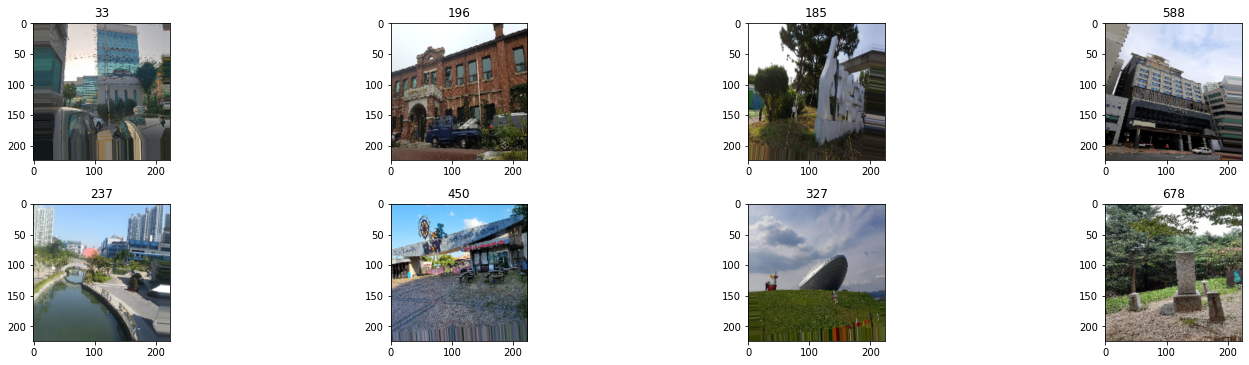

In [48]:
# 시각화 해보기
plt.figure(figsize=(20,20))
for i in range(0,8):
    plt.subplot(8,4,i+1)
    for xBatch, yBatch in train_generator:
        image = xBatch[0]
        plt.title(yBatch[0])
        plt.imshow(image)
        break
plt.tight_layout()
plt.show()

## 저장된 데이터 불러오기(넘파이) 

In [2]:
path = "./landmark"
x_train = np.load(path + "/x_train.npy")
y_train = np.load(path + "/y_train.npy")
x_valid = np.load(path + "/x_valid.npy")
y_valid = np.load(path + "/y_valid.npy")

In [3]:
print(x_train.shape)
print(y_train.shape)
print(x_valid.shape)
print(y_valid.shape)

(70481, 224, 224, 3)
(70481,)
(17621, 224, 224, 3)
(17621,)


## 모델링  

### Base-CNN 

In [5]:
model = Sequential()

model.add(Conv2D(32, (3, 3), activation='relu', input_shape=(224, 224, 3)))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))

model.add(Conv2D(64, (3, 3), activation='relu'))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))

model.add(Conv2D(128, (3, 3), activation='relu'))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))

model.add(Flatten())
model.add(Dense(512, activation='relu'))
model.add(BatchNormalization())
model.add(Dropout(0.5))
model.add(Dense(1049, activation='softmax')) 

model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 222, 222, 32)      896       
_________________________________________________________________
batch_normalization (BatchNo (None, 222, 222, 32)      128       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 111, 111, 32)      0         
_________________________________________________________________
dropout (Dropout)            (None, 111, 111, 32)      0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 109, 109, 64)      18496     
_________________________________________________________________
batch_normalization_1 (Batch (None, 109, 109, 64)      256       
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 54, 54, 64)        0

In [6]:

earlystop = EarlyStopping(patience=10)
learning_rate_reduction=ReduceLROnPlateau(
                        monitor= "val_accuracy", 
                        patience = 2, 
                        factor = 0.5, 
                        min_lr=0.0001,
                        verbose=1)
model_check = ModelCheckpoint( #에포크마다 현재 가중치를 저장
        filepath="landamark_base_CNN_model.h5", #모델 파일 경로
        monitor='val_loss',  # val_loss 가 좋아지지 않으면 모델 파일을 덮어쓰지 않음.
        save_best_only=True)


callbacks = [earlystop, learning_rate_reduction, model_check]

In [7]:
model.compile(loss='sparse_categorical_crossentropy',
              optimizer='adam',
              metrics=['accuracy'])

In [13]:
# from tensorflow.keras.models import load_model
# model = load_model('landamark_base_CNN_model.h5')
# model.summary()

In [8]:
history = model.fit(x_train,
    y_train,
    batch_size=128,
    epochs=50,
    validation_data=(x_valid, y_valid),
    callbacks = callbacks,
)

Epoch 1/50
551/551 [==============================] - 168s 304ms/step - loss: 3.6794 - accuracy: 0.3867 - val_loss: 4.8641 - val_accuracy: 0.2410
Epoch 2/50
551/551 [==============================] - 160s 291ms/step - loss: 1.0872 - accuracy: 0.7765 - val_loss: 1.2375 - val_accuracy: 0.7363
Epoch 3/50
551/551 [==============================] - 160s 291ms/step - loss: 0.4746 - accuracy: 0.8952 - val_loss: 0.9427 - val_accuracy: 0.7963
Epoch 4/50
551/551 [==============================] - ETA: 0s - loss: 0.2150 - accuracy: 0.9513

KeyboardInterrupt: 

## VGG16 

In [19]:
earlystop = EarlyStopping(patience=10)
learning_rate_reduction=ReduceLROnPlateau(
                        monitor= "val_accuracy", 
                        patience = 2, 
                        factor = 0.5, 
                        min_lr=0.0001,
                        verbose=1)
model_check = ModelCheckpoint( #에포크마다 현재 가중치를 저장
        filepath="landamark_VGG16_model.h5", #모델 파일 경로
        monitor='val_loss',  # val_loss 가 좋아지지 않으면 모델 파일을 덮어쓰지 않음.
        save_best_only=True)


callbacks = [earlystop, learning_rate_reduction, model_check]

In [20]:
from tensorflow.keras.applications import VGG16
conv_base = VGG16(weights='imagenet', include_top=False, input_shape=(224,224,3))

model = models.Sequential()
model.add(conv_base)
model.add(layers.Flatten())
model.add(Dense(1049, activation='softmax')) 
model.summary()

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
vgg16 (Functional)           (None, 7, 7, 512)         14714688  
_________________________________________________________________
flatten_3 (Flatten)          (None, 25088)             0         
_________________________________________________________________
dense_5 (Dense)              (None, 1049)              26318361  
Total params: 41,033,049
Trainable params: 41,033,049
Non-trainable params: 0
_________________________________________________________________


In [21]:
model.compile(loss='sparse_categorical_crossentropy',
              optimizer='adam',
              metrics=['accuracy'])

In [22]:
history = model.fit(x_train,
    y_train,
    batch_size=128,
    epochs=50,
    validation_data=(x_valid, y_valid),
    callbacks = callbacks,
)

Epoch 1/50
 87/551 [===>..........................] - ETA: 12:24 - loss: 6.9769 - accuracy: 0.0011 

KeyboardInterrupt: 

### ResNet (config 문제 해결 중)

In [5]:
earlystop = EarlyStopping(patience=10)
learning_rate_reduction=ReduceLROnPlateau(
                        monitor= "val_accuracy", 
                        patience = 2, 
                        factor = 0.5, 
                        min_lr=0.0001,
                        verbose=1)
model_check = ModelCheckpoint( #에포크마다 현재 가중치를 저장
        filepath="landamark_ResNet_model.h5", #모델 파일 경로
        monitor='val_loss',  # val_loss 가 좋아지지 않으면 모델 파일을 덮어쓰지 않음.
        save_best_only=True)


callbacks = [earlystop, learning_rate_reduction, model_check]

In [6]:
from functools import partial
DefaultConv2D = partial(tf.keras.layers.Conv2D, kernel_size=3, strides=1,
                        padding="SAME", use_bias=False)
class ResidualUnit(tf.keras.layers.Layer):
    def __init__(self, filters, strides=1, activation="relu", **kwargs):
        super().__init__(**kwargs)
        self.activation = tf.keras.activations.get(activation)
        self.main_layers = [
            DefaultConv2D(filters, strides=strides),
            tf.keras.layers.BatchNormalization(),
            self.activation,
            DefaultConv2D(filters),
            tf.keras.layers.BatchNormalization()]
        self.skip_layers = []
        if strides > 1:
            self.skip_layers = [
                DefaultConv2D(filters, kernel_size=1, strides=strides),
                tf.keras.layers.BatchNormalization()]
            
    def call(self, inputs):
        Z = inputs
        for layer in self.main_layers:
            Z = layer(Z)
            skip_Z = inputs
        for layer in self.skip_layers:
            skip_Z = layer(skip_Z)
        return self.activation(Z + skip_Z)

In [7]:
model = tf.keras.models.Sequential()
model.add(DefaultConv2D(64, kernel_size=7, strides=2,
                    input_shape=[224, 224, 3]))
model.add(tf.keras.layers.BatchNormalization())
model.add(tf.keras.layers.Activation("relu"))
model.add(tf.keras.layers.MaxPool2D(pool_size=3, strides=2, padding="SAME"))
prev_filters = 64
for filters in [64] * 3 + [128] * 4 + [256] * 6 + [512] * 3:
    strides = 1 if filters == prev_filters else 2
    model.add(ResidualUnit(filters, strides=strides))
    model.add(tf.keras.layers.BatchNormalization())
    prev_filters = filters
model.add(tf.keras.layers.GlobalAvgPool2D())
model.add(tf.keras.layers.Flatten())
model.add(Dense(512, activation='relu'))
model.add(BatchNormalization())
model.add(Dropout(0.5))
model.add(tf.keras.layers.Dense(1049, activation="softmax"))
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 112, 112, 64)      9408      
_________________________________________________________________
batch_normalization (BatchNo (None, 112, 112, 64)      256       
_________________________________________________________________
activation (Activation)      (None, 112, 112, 64)      0         
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 56, 56, 64)        0         
_________________________________________________________________
residual_unit (ResidualUnit) (None, 56, 56, 64)        74240     
_________________________________________________________________
batch_normalization_3 (Batch (None, 56, 56, 64)        256       
_________________________________________________________________
residual_unit_1 (ResidualUni (None, 56, 56, 64)        7

In [8]:
model.compile(loss='sparse_categorical_crossentropy',
              optimizer='adam',
              metrics=['accuracy'])

In [9]:
history = model.fit(x_train,
    y_train,
    batch_size=128,
    epochs=50,
    validation_data=(x_valid, y_valid),
    callbacks = callbacks,
)

Epoch 1/50
551/551 [==============================] - ETA: 0s - loss: 4.8403 - accuracy: 0.1727

NotImplementedError: Layer ResidualUnit has arguments in `__init__` and therefore must override `get_config`.

## MobileNet V2 (0.975) 

In [43]:
earlystop = EarlyStopping(patience=10)
learning_rate_reduction=ReduceLROnPlateau(
                        monitor= "val_accuracy", 
                        patience = 2, 
                        factor = 0.5, 
                        min_lr=0.00001,
                        verbose=1)
model_check = ModelCheckpoint( #에포크마다 현재 가중치를 저장
        filepath="landamark_MobileNetv2_model_2.h5", #모델 파일 경로
        monitor='val_loss',  # val_loss 가 좋아지지 않으면 모델 파일을 덮어쓰지 않음.
        save_best_only=True)


callbacks = [earlystop, learning_rate_reduction, model_check]

In [8]:
from tensorflow.keras.applications import MobileNetV2
mobilenet = MobileNetV2(weights='imagenet', include_top=False, input_shape=(224,224,3))

for layer in mobilenet.layers:
    layer.trainable = True

for (i, layer) in enumerate(mobilenet.layers):
    print(str(i), layer.__class__.__name__, layer.trainable)
    
model = models.Sequential()
model.add(mobilenet)
model.add(layers.Flatten())
model.add(Dense(512, activation='relu', kernel_initializer='he_normal'))
model.add(BatchNormalization())
model.add(Dropout(0.5))
model.add(Dense(1049, activation='softmax')) 
model.summary()

0 InputLayer True
1 ZeroPadding2D True
2 Conv2D True
3 BatchNormalization True
4 ReLU True
5 DepthwiseConv2D True
6 BatchNormalization True
7 ReLU True
8 Conv2D True
9 BatchNormalization True
10 Conv2D True
11 BatchNormalization True
12 ReLU True
13 ZeroPadding2D True
14 DepthwiseConv2D True
15 BatchNormalization True
16 ReLU True
17 Conv2D True
18 BatchNormalization True
19 Conv2D True
20 BatchNormalization True
21 ReLU True
22 DepthwiseConv2D True
23 BatchNormalization True
24 ReLU True
25 Conv2D True
26 BatchNormalization True
27 Add True
28 Conv2D True
29 BatchNormalization True
30 ReLU True
31 ZeroPadding2D True
32 DepthwiseConv2D True
33 BatchNormalization True
34 ReLU True
35 Conv2D True
36 BatchNormalization True
37 Conv2D True
38 BatchNormalization True
39 ReLU True
40 DepthwiseConv2D True
41 BatchNormalization True
42 ReLU True
43 Conv2D True
44 BatchNormalization True
45 Add True
46 Conv2D True
47 BatchNormalization True
48 ReLU True
49 DepthwiseConv2D True
50 BatchNormaliza

In [44]:
model.compile(loss='sparse_categorical_crossentropy',
              optimizer=Adam(learning_rate=0.00005),
              metrics=['accuracy'])

In [45]:
history = model.fit(x_train,
    y_train,
    batch_size=128,
    epochs=50,
    validation_data=(x_valid, y_valid),
    callbacks = callbacks,
)

Epoch 1/50
551/551 [==============================] - 466s 846ms/step - loss: 4.7291e-04 - accuracy: 0.9999 - val_loss: 0.0835 - val_accuracy: 0.9818
Epoch 2/50
551/551 [==============================] - 465s 844ms/step - loss: 3.3434e-04 - accuracy: 0.9999 - val_loss: 0.0825 - val_accuracy: 0.9820
Epoch 3/50
551/551 [==============================] - 469s 850ms/step - loss: 2.3652e-04 - accuracy: 1.0000 - val_loss: 0.0821 - val_accuracy: 0.9816
Epoch 4/50
 20/551 [>.............................] - ETA: 6:41 - loss: 1.9654e-04 - accuracy: 1.0000

KeyboardInterrupt: 

## 제출파일 생성 

In [46]:
from tensorflow.keras.models import load_model
model = load_model('landamark_MobileNetv2_model_2.h5')
model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
mobilenetv2_1.00_224 (Functi (None, 7, 7, 1280)        2257984   
_________________________________________________________________
flatten_1 (Flatten)          (None, 62720)             0         
_________________________________________________________________
dense_2 (Dense)              (None, 512)               32113152  
_________________________________________________________________
batch_normalization_1 (Batch (None, 512)               2048      
_________________________________________________________________
dropout_1 (Dropout)          (None, 512)               0         
_________________________________________________________________
dense_3 (Dense)              (None, 1049)              538137    
Total params: 34,911,321
Trainable params: 34,876,185
Non-trainable params: 35,136
_____________________________________

In [47]:
path = "./landmark"
test_data = np.load(path + "/test_data.npy")

In [48]:
submission = pd.read_csv(path + '/sample_submisstion.csv')

In [49]:
pred = model.predict(test_data)
landmark_id = np.argmax(pred, axis=1)
conf = np.max(pred, axis=1)

pred_df = pd.read_csv(path + '/test_id.csv')
pred_df['landmark_id'] = landmark_id
pred_df['conf'] = np.max(pred,axis=1)
pred_df.head()

,id,landmark_id,conf
0,45t1hg1to5,213,1.000000
1,thsabpw2ik,690,1.000000
2,2y2a0a1ke9,177,0.948837
3,i5pbvequeq,799,1.000000
4,kx4tjod8s6,775,1.000000


In [50]:
sub = pd.merge(submission[['id']], pred_df, on='id', how='left')
sub.head()
sub.to_csv(path + '/MobileNetV2_model_2.csv', encoding='cp949', index=False)